<a href="https://colab.research.google.com/github/nericovich/project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для задачи Яндекс Лицея "Анализ экологических проблем"

### На заводе по производству полезного полимера ООО “Synthesising the future“ обратились за помощью в исследовании зависимостей вредных выбросов от производственных показателей. Требуется повести анализ данных и построить выводы о том, какой этап имеет высокий риск создать повышенное содержания вредного газа.


## Импорты

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind, shapiro

In [2]:
df = pd.read_csv('data.csv', sep=',', decimal='.', skipinitialspace=True)

## Исследование данных на качество


### Исследование типов данных 

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
df.head(4)

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,2021-01-28 18:00:00,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,108.65,45.59,156.67,19.08,5.92,356.05,NaN,21.48,47.03,2.0
1,2021-01-28 19:00:00,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,108.71,45.89,156.76,19.15,5.94,357.69,NaN,21.48,45.05,2.0
2,2021-01-28 20:00:00,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,108.76,46.19,156.86,19.23,5.97,359.33,NaN,21.48,43.06,2.0
3,2021-01-28 21:00:00,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,108.63,45.87,156.41,19.36,5.97,339.99,0.16,21.48,46.01,2.0


Оставляем только те строки, где есть целевой фактор - 'stage_4_output_danger_gas' 

In [5]:
df = df.dropna(subset=['stage_4_output_danger_gas'])
df = df.reset_index(drop=True)

In [6]:
df.dtypes

datetime                                 object
stage_1_output_konv_avd                 float64
stage_2_input_water_sum                 float64
stage_2_output_bottom_pressure          float64
stage_2_output_bottom_temp              float64
stage_2_output_bottom_temp_hum_steam    float64
stage_2_output_bottom_vacuum            float64
stage_2_output_top_pressure             float64
stage_2_output_top_pressure_at_end      float64
stage_2_output_top_temp                 float64
stage_2_output_top_vacuum               float64
stage_3_input_pressure                  float64
stage_3_input_soft_water                float64
stage_3_input_steam                     float64
stage_3_output_temp_hum_steam           float64
stage_3_output_temp_top                 float64
stage_4_input_overheated_steam          float64
stage_4_input_polymer                   float64
stage_4_input_steam                     float64
stage_4_input_water                     float64
stage_4_output_danger_gas               

### Пропуски

In [7]:
df.isna().sum()

datetime                                 0
stage_1_output_konv_avd                 12
stage_2_input_water_sum                 15
stage_2_output_bottom_pressure          18
stage_2_output_bottom_temp               8
stage_2_output_bottom_temp_hum_steam     4
stage_2_output_bottom_vacuum            24
stage_2_output_top_pressure              4
stage_2_output_top_pressure_at_end       1
stage_2_output_top_temp                  9
stage_2_output_top_vacuum               10
stage_3_input_pressure                  17
stage_3_input_soft_water                10
stage_3_input_steam                      1
stage_3_output_temp_hum_steam            2
stage_3_output_temp_top                 14
stage_4_input_overheated_steam           2
stage_4_input_polymer                   10
stage_4_input_steam                     26
stage_4_input_water                     21
stage_4_output_danger_gas                0
stage_4_output_dry_residue_avg           0
stage_4_output_product                   0
work_shift 

'stage_4_input_water' - подача воды, в м3  
Вероятно, ошибки или сбои, тк воду точно подавали, распределение не нормальное - используем медиану

302.10960569550934
285.56


<Axes: xlabel='stage_4_input_water', ylabel='Count'>

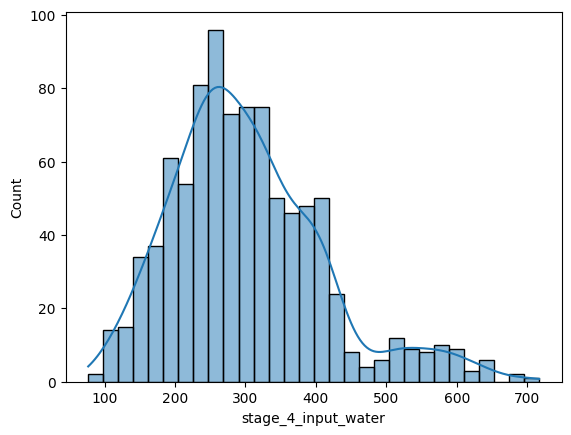

In [8]:
print(df['stage_4_input_water'].mean())
print(df['stage_4_input_water'].median())
sns.histplot(df['stage_4_input_water'], kde=True, bins=30)

In [9]:
df['stage_4_input_water'] = df['stage_4_input_water'].fillna(df['stage_4_input_water'].median())
df['stage_4_input_water'].isna().sum()


0

'stage_4_input_steam' - подача пара, в м3  
Распределение не нормальное - используем медиану

5.340594713656388
5.305


<Axes: xlabel='stage_4_input_steam', ylabel='Count'>

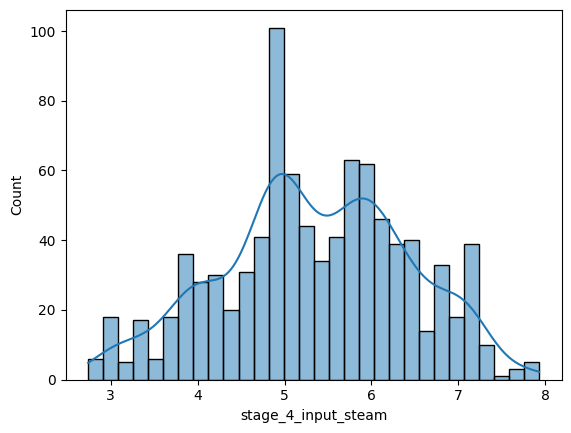

In [10]:
print(df['stage_4_input_steam'].mean())
print(df['stage_4_input_steam'].median())
sns.histplot(df['stage_4_input_steam'], kde=True, bins=30)

In [11]:
df['stage_4_input_steam'] = df['stage_4_input_steam'].fillna(df['stage_4_input_steam'].median())
df['stage_4_input_steam'].isna().sum()

0

'stage_4_input_polymer' - подача полимера, в м3  
Распределение не нормальное - используем медиану

20.090119047619044
20.475


<Axes: xlabel='stage_4_input_polymer', ylabel='Count'>

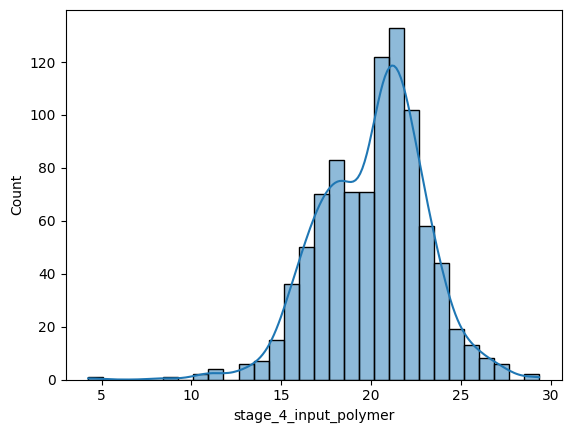

In [12]:
print(df['stage_4_input_polymer'].mean())
print(df['stage_4_input_polymer'].median())
sns.histplot(df['stage_4_input_polymer'], kde=True, bins=30)

In [13]:
df['stage_4_input_polymer'] = df['stage_4_input_polymer'].fillna(df['stage_4_input_polymer'].median())
df['stage_4_input_polymer'].isna().sum()

0

'stage_4_input_overheated_steam' - подача перегретого пара, в м3  
Распределение не нормальное - используем медиану

153.30983905579401
153.165


<Axes: xlabel='stage_4_input_overheated_steam', ylabel='Count'>

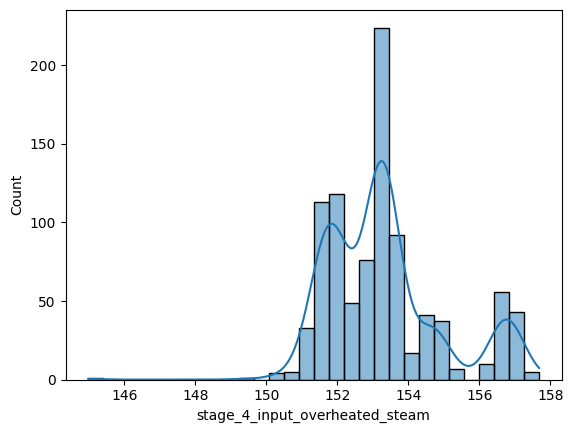

In [14]:
print(df['stage_4_input_overheated_steam'].mean())
print(df['stage_4_input_overheated_steam'].median())
sns.histplot(df['stage_4_input_overheated_steam'], kde=True, bins=30)

In [15]:
df['stage_4_input_overheated_steam'] = df['stage_4_input_overheated_steam'].fillna(df['stage_4_input_overheated_steam'].median())
df['stage_4_input_overheated_steam'].isna().sum()

0

'stage_3_output_temp_top' - температура верха в агрегате, в градусах Цельсия  
Распределение не нормальное - используем медиану

42.27872826086956
43.935


<Axes: xlabel='stage_3_output_temp_top', ylabel='Count'>

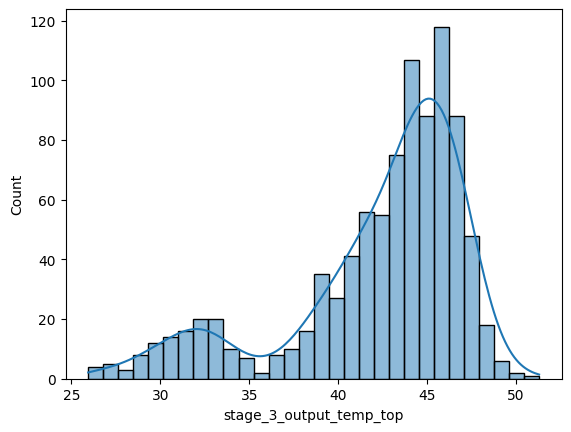

In [16]:
print(df['stage_3_output_temp_top'].mean())
print(df['stage_3_output_temp_top'].median())
sns.histplot(df['stage_3_output_temp_top'], kde=True, bins=30)

In [17]:
df['stage_3_output_temp_top'] = df['stage_3_output_temp_top'].fillna(df['stage_3_output_temp_top'].median())

'stage_3_output_temp_hum_steam' - температура насыщенного пара, в градусах Цельсия  
Распределение не нормальное - используем медиану

109.5799678111588
109.095


<Axes: xlabel='stage_3_output_temp_hum_steam', ylabel='Count'>

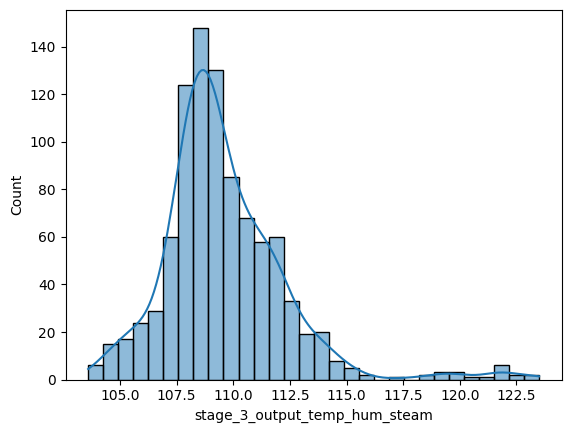

In [18]:
print(df['stage_3_output_temp_hum_steam'].mean())
print(df['stage_3_output_temp_hum_steam'].median())
sns.histplot(df['stage_3_output_temp_hum_steam'], kde=True, bins=30)

In [19]:
df['stage_3_output_temp_hum_steam'] = df['stage_3_output_temp_hum_steam'].fillna(df['stage_3_output_temp_hum_steam'].median())

'stage_3_input_steam'- подаваемый пар, в м3  
Распределение не нормальное - используем медиану 

823.0909110396569
775.1


<Axes: xlabel='stage_3_input_steam', ylabel='Count'>

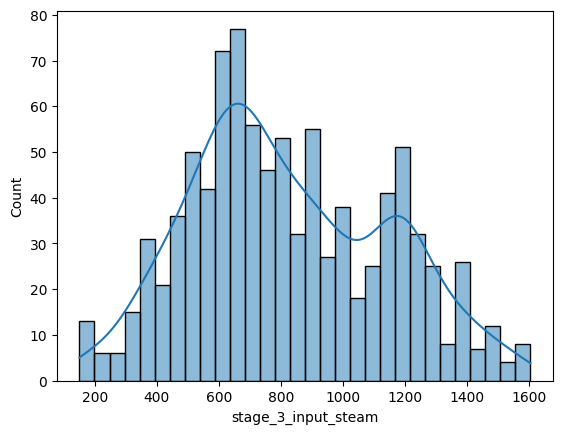

In [20]:
print(df['stage_3_input_steam'].mean())
print(df['stage_3_input_steam'].median())
sns.histplot(df['stage_3_input_steam'], kde=True, bins=30)

In [21]:
df['stage_3_input_steam'] = df['stage_3_input_steam'].fillna(df['stage_3_input_steam'].median())

'stage_3_input_soft_water' - подаваемая смягченная вода, в м3  
Распределение не нормальное - используем медиану

303.6336147186147
288.805


<Axes: xlabel='stage_3_input_soft_water', ylabel='Count'>

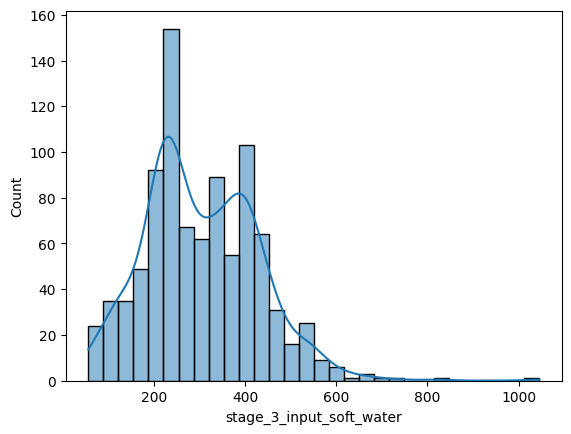

In [22]:
print(df['stage_3_input_soft_water'].mean())
print(df['stage_3_input_soft_water'].median())
sns.histplot(df['stage_3_input_soft_water'], kde=True, bins=30)

In [23]:
df['stage_3_input_soft_water'] = df['stage_3_input_soft_water'].fillna(df['stage_3_input_soft_water'].median())

'stage_3_input_pressure' - подаваемое давление в агрегат, в кПа  
Распределение не нормальное - используем медиану

0.33138495092693565
0.33


<Axes: xlabel='stage_3_input_pressure', ylabel='Count'>

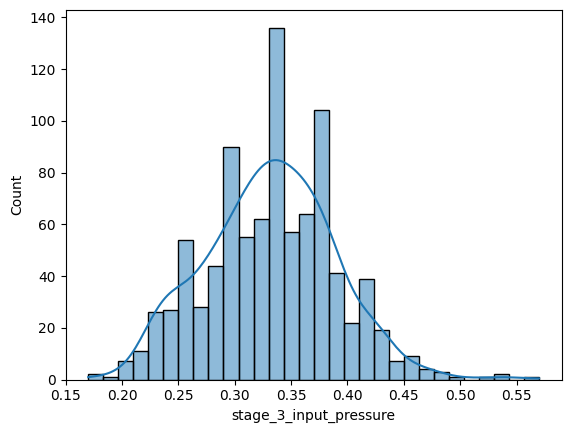

In [24]:
print(df['stage_3_input_pressure'].mean())
print(df['stage_3_input_pressure'].median())
sns.histplot(df['stage_3_input_pressure'], kde=True, bins=30)

In [25]:
df['stage_3_input_pressure'] = df['stage_3_input_pressure'].fillna(df['stage_3_input_pressure'].median())

'stage_2_output_top_vacuum' - вакуум низа в агрегате, в кПа  
Распределение не нормальное - используем медиану

58.5492316017316


56.239999999999995


<Axes: xlabel='stage_2_output_top_vacuum', ylabel='Count'>

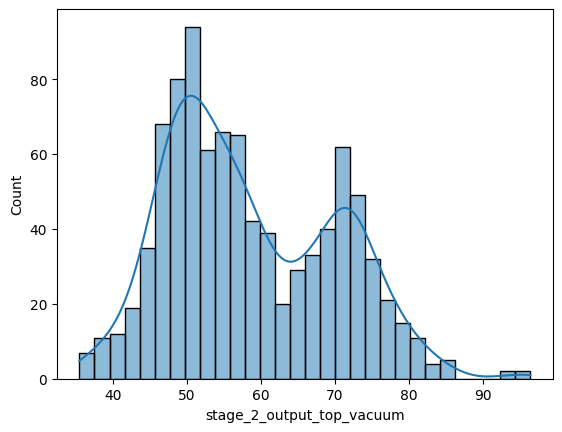

In [26]:
print(df['stage_2_output_top_vacuum'].mean())
print(df['stage_2_output_top_vacuum'].median())
sns.histplot(df['stage_2_output_top_vacuum'], kde=True, bins=30)

In [27]:
df['stage_2_output_top_vacuum'] = df['stage_2_output_top_vacuum'].fillna(df['stage_2_output_top_vacuum'].median())

'stage_2_output_top_temp' - температура низа в агрегате, в градусах Цельсия  
Распределение не нормальное - используем медиану 

94.53408648648649
95.31


<Axes: xlabel='stage_2_output_top_temp', ylabel='Count'>

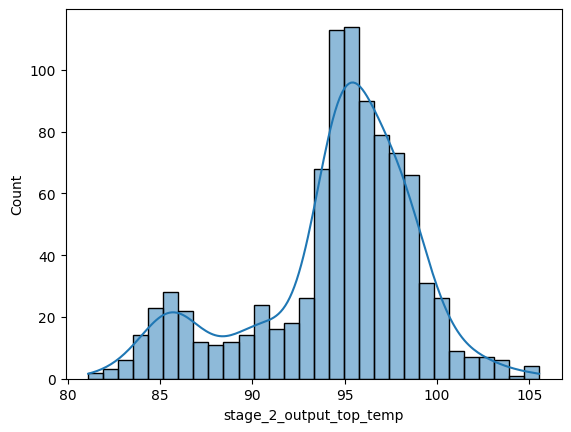

In [28]:
print(df['stage_2_output_top_temp'].mean())
print(df['stage_2_output_top_temp'].median())
sns.histplot(df['stage_2_output_top_temp'], kde=True, bins=30)

In [29]:
df['stage_2_output_top_temp'] = df['stage_2_output_top_temp'].fillna(df['stage_2_output_top_temp'].median())

'stage_2_output_top_pressure_at_end' - давление верха в агрегате на выходе, в кПа  
Распределение почти нормальное - используем среднее 

262.83628081457664
261.2


<Axes: xlabel='stage_2_output_top_pressure_at_end', ylabel='Count'>

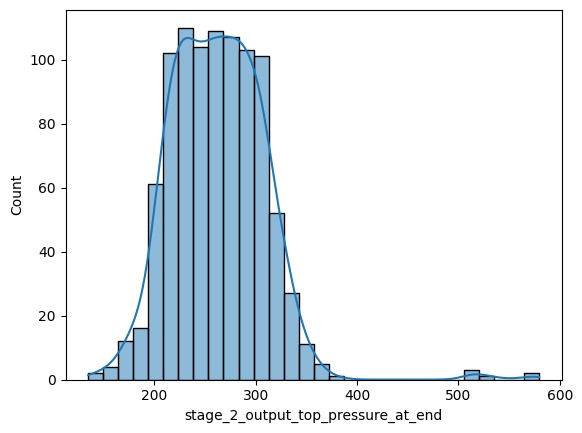

In [30]:
print(df['stage_2_output_top_pressure_at_end'].mean())
print(df['stage_2_output_top_pressure_at_end'].median())
sns.histplot(df['stage_2_output_top_pressure_at_end'], kde=True, bins=30)

In [31]:
df['stage_2_output_top_pressure_at_end'] = df['stage_2_output_top_pressure_at_end'].fillna(df['stage_2_output_top_pressure_at_end'].mean())

'stage_2_output_top_pressure' - давление верха (top) в агрегате, в кПа  
Распределение не нормальное - используем медиану 

453.19545161290324
433.12


<Axes: xlabel='stage_2_output_top_pressure', ylabel='Count'>

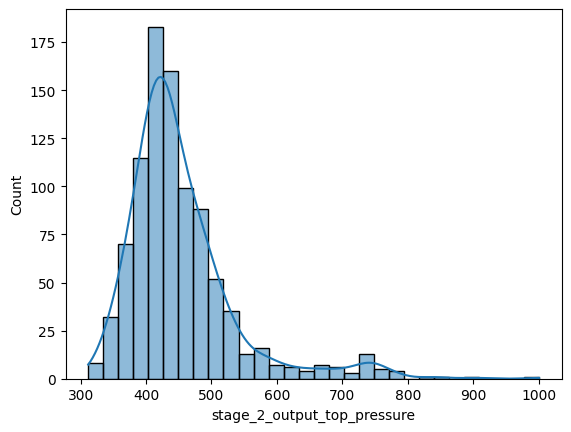

In [32]:

print(df['stage_2_output_top_pressure'].mean())
print(df['stage_2_output_top_pressure'].median())
sns.histplot(df['stage_2_output_top_pressure'], kde=True, bins=30)

In [33]:
df['stage_2_output_top_pressure'] = df['stage_2_output_top_pressure'].fillna(df['stage_2_output_top_pressure'].median())

'stage_2_output_bottom_vacuum' - вакуум низа в агрегате, в кПа  
Распределение не нормальное - используем медиану 

56.67148351648352
56.105000000000004


<Axes: xlabel='stage_2_output_bottom_vacuum', ylabel='Count'>

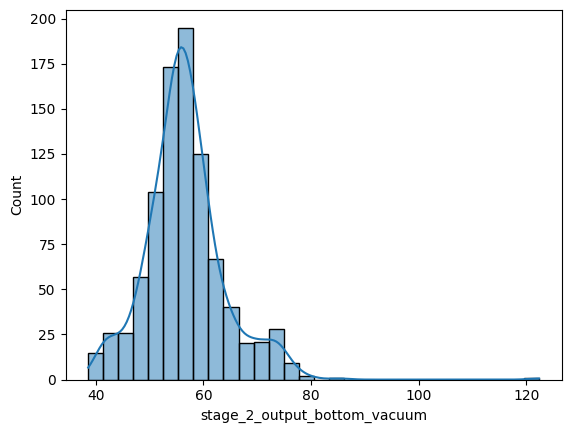

In [34]:

print(df['stage_2_output_bottom_vacuum'].mean())
print(df['stage_2_output_bottom_vacuum'].median())
sns.histplot(df['stage_2_output_bottom_vacuum'], kde=True, bins=30)

In [35]:
df['stage_2_output_bottom_vacuum'] = df['stage_2_output_bottom_vacuum'].fillna(df['stage_2_output_bottom_vacuum'].median())

'stage_2_output_bottom_temp_hum_steam' - температура насыщенного пара низа в агрегате, в градусах Цельсия  
Распределение не нормальное - используем медиану 

98.03411827956991
96.37


<Axes: xlabel='stage_2_output_bottom_temp_hum_steam', ylabel='Count'>

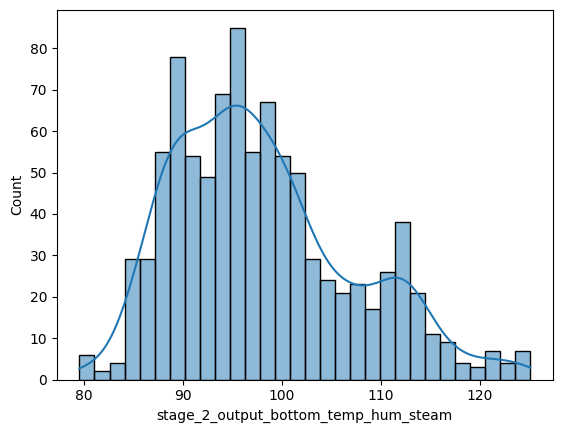

In [36]:
print(df['stage_2_output_bottom_temp_hum_steam'].mean())
print(df['stage_2_output_bottom_temp_hum_steam'].median())
sns.histplot(df['stage_2_output_bottom_temp_hum_steam'], kde=True, bins=30)

In [37]:
df['stage_2_output_bottom_temp_hum_steam'] = df['stage_2_output_bottom_temp_hum_steam'].fillna(df['stage_2_output_bottom_temp_hum_steam'].median())

'stage_2_output_bottom_temp' - температура низа в агрегате, в градусах Цельсия  
Распределение нормальное - используем среднее

78.94448164146868
78.6


<Axes: xlabel='stage_2_output_bottom_temp', ylabel='Count'>

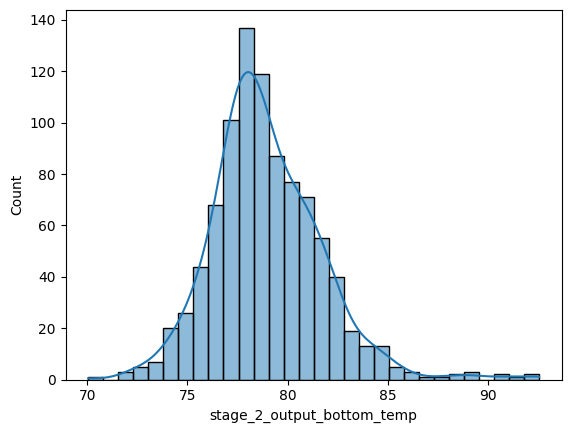

In [38]:
print(df['stage_2_output_bottom_temp'].mean())
print(df['stage_2_output_bottom_temp'].median())
sns.histplot(df['stage_2_output_bottom_temp'], kde=True, bins=30)

In [39]:
df['stage_2_output_bottom_temp'] = df['stage_2_output_bottom_temp'].fillna(df['stage_2_output_bottom_temp'].mean())

'stage_2_output_bottom_pressure' - давление низа (bottom) в агрегате, в кПа  
Распределение не нормальное - используем медиану 

395.1518995633188
376.485


<Axes: xlabel='stage_2_output_bottom_pressure', ylabel='Count'>

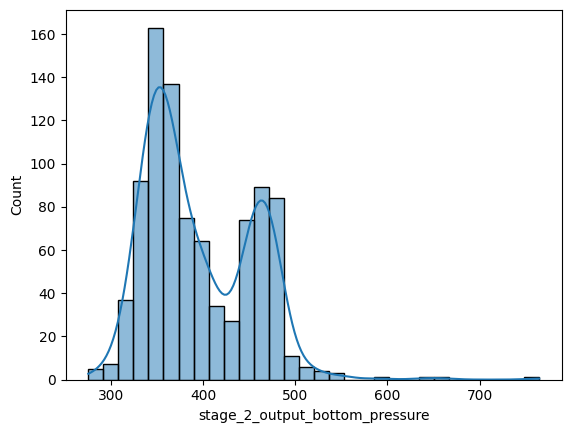

In [40]:
print(df['stage_2_output_bottom_pressure'].mean())
print(df['stage_2_output_bottom_pressure'].median())
sns.histplot(df['stage_2_output_bottom_pressure'], kde=True, bins=30)

In [41]:
df['stage_2_output_bottom_pressure'] = df['stage_2_output_bottom_pressure'].fillna(df['stage_2_output_bottom_pressure'].median())

'stage_2_input_water_sum' - количество подаваемой суммарной воды в агрегат, в м3.  
Распределение не нормальное - используем медиану 

87.33003264417846
83.85


<Axes: xlabel='stage_2_input_water_sum', ylabel='Count'>

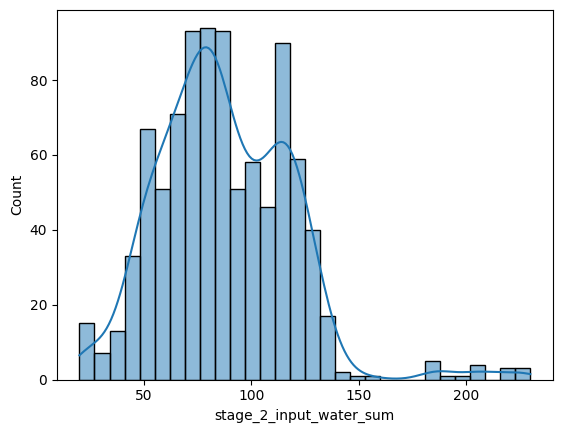

In [42]:
print(df['stage_2_input_water_sum'].mean())
print(df['stage_2_input_water_sum'].median())
sns.histplot(df['stage_2_input_water_sum'], kde=True, bins=30)

In [43]:

df['stage_2_input_water_sum'] = df['stage_2_input_water_sum'].fillna(df['stage_2_input_water_sum'].median())

'stage_1_output_konv_avd' - процент конверсии сырья в мономер.  
Различия медианы и среднего мало, распределение выглядит почти нормальным, можно брать и среднее и медиану

69.06004338394794
69.33


<Axes: xlabel='stage_1_output_konv_avd', ylabel='Count'>

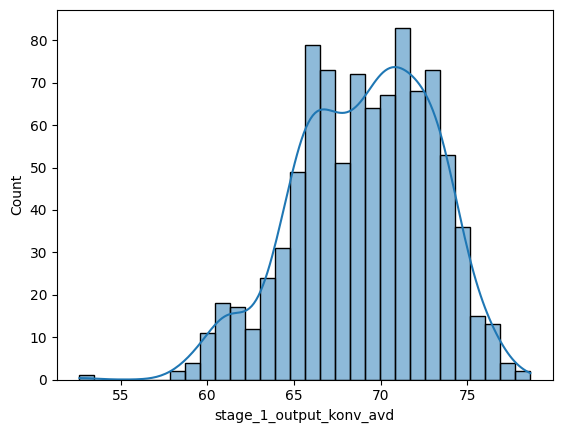

In [44]:
print(df['stage_1_output_konv_avd'].mean())
print(df['stage_1_output_konv_avd'].median())
sns.histplot(df['stage_1_output_konv_avd'], kde=True, bins=30)

In [45]:

df['stage_1_output_konv_avd'] = df['stage_1_output_konv_avd'].fillna(df['stage_1_output_konv_avd'].mean())

### Исследование выбросов

### Верхние и нижние границы

###  Аналитический и графический анализ данных

## Проведение расчётов

### Категория опасности 

In [46]:
df['danger_gas_kat'] = df['stage_4_output_danger_gas'].apply(
    lambda x: 1 if x < 0.05 else (2 if x >= 0.05 and x < 0.16 else 3))

df

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift,danger_gas_kat
0,2021-01-28 21:00:00,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,45.87,156.41,19.36,5.97,339.99,0.16,21.48,46.01,2.0,3
1,2021-01-29 01:00:00,71.23,105.97,475.01,76.90,98.28,51.24,370.37,260.85,98.14,...,45.74,156.46,22.93,5.73,319.95,0.15,21.98,52.55,2.0,2
2,2021-01-29 08:00:00,68.83,106.60,471.56,76.74,96.37,49.14,359.06,248.59,95.31,...,46.10,156.18,17.95,5.73,258.98,0.13,22.58,42.99,1.0,2
3,2021-01-29 21:00:00,68.73,104.05,465.82,75.31,96.24,45.14,341.09,224.87,96.27,...,45.84,156.62,15.20,5.88,319.02,0.14,20.78,43.67,1.0,2
4,2021-01-30 01:00:00,66.03,103.28,468.38,77.53,96.48,52.44,373.44,267.24,96.80,...,45.99,156.51,18.52,5.71,297.12,0.15,21.28,47.43,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,2023-03-19 12:00:00,67.33,43.32,409.32,82.00,105.65,69.35,771.29,223.71,97.37,...,41.04,152.90,22.69,4.14,381.37,0.20,21.18,9.17,2.0,3
930,2023-03-20 00:00:00,68.83,62.24,377.84,79.82,104.80,61.08,781.76,183.36,97.70,...,46.40,152.53,21.38,4.15,381.77,0.14,21.08,10.79,2.0,2
931,2023-03-20 12:00:00,66.83,61.92,397.95,81.19,105.50,66.26,776.52,227.64,98.31,...,45.99,152.53,21.78,4.14,391.60,0.20,21.08,9.27,1.0,3
932,2023-03-21 01:00:00,70.03,62.80,378.37,79.16,110.50,63.16,845.66,223.15,103.01,...,47.70,151.80,22.44,3.66,460.04,0.18,22.38,10.11,1.0,3


###  Cводная таблица изменения параметров сгруппированная по дням 

### Cводная таблица изменения категории опасности сгруппированная по месяцам

### Среднее значение каждого параметра для каждой категории

### Корреляционный анализ

## Проверка гипотез

### Гипотеза 1. Если ли различия в доле опасного газа от смены?

### Гипотеза 2. Какая из смен лучше управляет температурой верха на этапе 3?

### Гипотеза 3. Конверсия мономера на 1 этапе влияет на количество подаваемой суммарной воды.

### Гипотеза 4. Количество выходного количества продукта связано с долей опасного газа

### Гипотеза 5

### Гипотеза 6

### Гипотеза 7

### Гипотеза 8

## Регрессионное моделирование

### Моделирование для доли опасного газа